## Building a Hangul classifier
### By Dokyun Kim

This project focuses on developing a machine learning model capable of classifying handwritten Hangul characters from the Korean alphabet. As Korean media and culture continue to gain global popularity, an increasing number of people are learning Korean as a second language. This model can be used as an educational tool to enhance the language learning experience by helping students recognize and practice writing various Hangul characters. It could aid learners in quickly identifying character shapes, reinforcing their familiarity with characters, and improving handwriting skills. This model aims support learners in developing a stronger foundation in the Korean language.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchsummary import summary
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Currently using {device}")

# Set both to False if model is already saved locally (.pth)
TRAIN_MLP = True
TRAIN_LENET = True

Currently using cuda


## Handwritten Hangul Dataset

To train the model, we are utilizing the *Handwritten Hangul Characters* dataset from Kaggle, which contains 2,400 images of individual Hangul characters, each sized at 28x28 pixels. Since our model is designed to work exclusively with grayscale images, we first pre-process the dataset by converting all images to grayscale. This step ensures compatibility with the model’s input requirements.

To improve the model's robustness, we added an augmented dataset to the original dataset. We applied a random rotation of -20 to 20 degrees to each image, which enhances the model's performance on various handwriting styles and orientations.

In [22]:
transform_unaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1]
])

transform_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=(-20,20), fill=255), # Apply random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1]
])

dataset_unaug = datasets.ImageFolder(root='data/', transform=transform_unaug)
dataset_aug = datasets.ImageFolder(root='data/', transform=transform_aug)

# Combine unaugmented & augmented dataset into one
dataset_all = ConcatDataset([dataset_unaug, dataset_aug])

# Split dataset into 70% train, 30% test
train_size, test_size = 0.7, 0.3
batch_size = 40


train_set, test_set = random_split(dataset_all, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"{len(dataset_all)} total images")
for images, labels in train_loader:
    print('Image Batch Dimension: ', images.shape)
    print('Image Labels Dimension: ', labels.shape)
    break

print(dataset_aug.classes)

4800 total images
Image Batch Dimension:  torch.Size([40, 1, 28, 28])
Image Labels Dimension:  torch.Size([40])
['a', 'ae', 'b', 'bb', 'ch', 'd', 'e', 'eo', 'eu', 'g', 'gg', 'h', 'i', 'j', 'k', 'm', 'n', 'ng', 'o', 'p', 'r', 's', 'ss', 't', 'u', 'ya', 'yae', 'ye', 'yo', 'yu']


### Visualizing the dataset

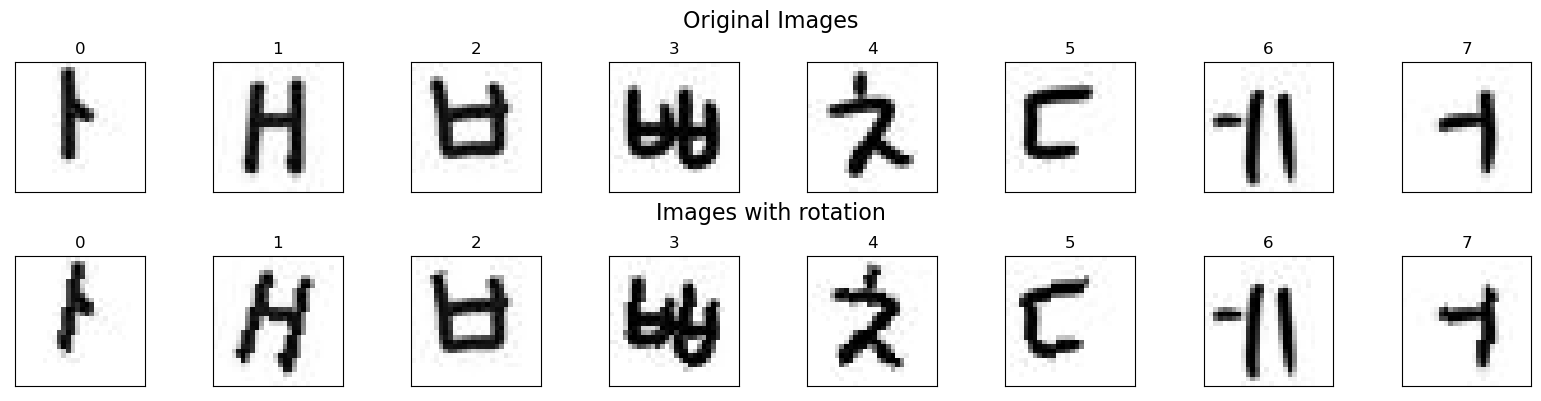

In [6]:
# Create a 2x8 grid of subplots
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

# Plot original images in the first row
for i in range(8):
    img, label = dataset_unaug[i*80]
    img = img.squeeze().numpy()
    axs[0, i].imshow(img, cmap='gray')
    axs[0, i].set_title(label)
    axs[0, i].axes.xaxis.set_visible(False)
    axs[0, i].axes.yaxis.set_visible(False)

# Plot augmented images in the second row
for i in range(8):
    img, label = dataset_aug[i*80]
    img = img.squeeze().numpy()
    axs[1, i].imshow(img, cmap='gray')
    axs[1, i].set_title(label)
    axs[1, i].axes.xaxis.set_visible(False)
    axs[1, i].axes.yaxis.set_visible(False)

# Add titles for each row of subplots
fig.text(0.5, 0.98, "Original Images", ha='center', fontsize=16, va='top')
fig.text(0.5, 0.5, "Images with rotation", ha='center', fontsize=16, va='top')

plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.5)

## Implementing a MLP solution

In the code block below, we define our MLP model. Since the task is quite simple (classify 30 classes), we will only use one hidden layer of size 203. The model details are printed below the code block.

In [7]:
# Define MLP object

class Hangul_MLP(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, input_size, num_classes):
        """
        Constructor for MLP object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(Hangul_MLP, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, (input_size + num_classes) // 4),
            nn.Sigmoid(),
            nn.Linear((input_size + num_classes) // 4, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        out = self.linear_stack(x)
        out = F.softmax(out, dim=1)
        return out

print(summary(Hangul_MLP(784, 30).to(device), (1,784)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 30]               --
|    └─Linear: 2-1                       [-1, 1, 203]              159,355
|    └─Sigmoid: 2-2                      [-1, 1, 203]              --
|    └─Linear: 2-3                       [-1, 1, 30]               6,120
|    └─Sigmoid: 2-4                      [-1, 1, 30]               --
Total params: 165,475
Trainable params: 165,475
Non-trainable params: 0
Total mult-adds (M): 0.33
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.63
Estimated Total Size (MB): 0.64
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 30]               --
|    └─Linear: 2-1                       [-1, 1, 203]              159,355
|    └─Sigmoid: 2-2                      [-1, 1, 203]              --
|    └─Linear: 2-3                       [-1, 1, 30]            

### MLP with batch training

In [8]:
def train_MLP_batch(trainloader: DataLoader, testloader: DataLoader, n_epochs: int, learning_rate: float):
    """
    Trains a model using the MLP architecture defined above

    Args:
        trainloader (Datalodaer): PyTorch Dataloader object with training set
        testloader (Dataloader): PyTorch Dataloader object with testing set
        n_epochs (int): Number of epochs
        learning_rate (float): Learning rate of model

    Returns:
        train_losses (list): List of train losses over n_epochs
        test_losses (list): List of test losses over n_epochs
        accuracies (list): List of accuracies over n_epochs
        model (Hangul_MLP): Trained MLP model
    """

    model = Hangul_MLP(input_size = 784, num_classes = 30).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = np.zeros((n_epochs,))
    test_losses = np.zeros((n_epochs,))
    accuracies = np.zeros((n_epochs,))

    start = time.time()
    for epoch in range(n_epochs):

        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():

            total_test_loss, total_train_loss, correct_preds = 0.0, 0.0, 0.0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

                test_outputs = model(images)
                test_loss = criterion(test_outputs, labels)
                total_test_loss += test_loss.item()
                
                _, preds = torch.max(test_outputs, 1)
                correct_preds += (preds == labels).sum().item()

            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

                train_outputs = model(images)
                train_loss = criterion(train_outputs, labels)
                total_train_loss += train_loss.item()

            accuracies[epoch] = correct_preds / len(testloader.dataset) * 100 # type: ignore
            test_losses[epoch] = total_test_loss / len(testloader)
            train_losses[epoch] = total_train_loss / len(trainloader)

            # print every 10 epochs so we don't get 300 lines of text output
            if epoch == 0 or (epoch+1)%10 == 0:
                print('Epoch: %03d/%03d | Accuracy: %.3f%%' %(epoch + 1, n_epochs, accuracies[epoch]))
        
    print("Total Train Time: %.2f min" % ((time.time() - start)/60))
    return train_losses, test_losses, accuracies, model

Epoch: 001/300 | Accuracy: 11.458%
Epoch: 010/300 | Accuracy: 69.722%
Epoch: 020/300 | Accuracy: 74.722%
Epoch: 030/300 | Accuracy: 78.611%
Epoch: 040/300 | Accuracy: 81.042%
Epoch: 050/300 | Accuracy: 82.083%
Epoch: 060/300 | Accuracy: 84.028%
Epoch: 070/300 | Accuracy: 84.236%
Epoch: 080/300 | Accuracy: 86.389%
Epoch: 090/300 | Accuracy: 86.875%
Epoch: 100/300 | Accuracy: 88.056%
Epoch: 110/300 | Accuracy: 89.028%
Epoch: 120/300 | Accuracy: 89.653%
Epoch: 130/300 | Accuracy: 89.792%
Epoch: 140/300 | Accuracy: 90.486%
Epoch: 150/300 | Accuracy: 91.319%
Epoch: 160/300 | Accuracy: 90.833%
Epoch: 170/300 | Accuracy: 91.597%
Epoch: 180/300 | Accuracy: 91.736%
Epoch: 190/300 | Accuracy: 91.597%
Epoch: 200/300 | Accuracy: 91.875%
Epoch: 210/300 | Accuracy: 91.667%
Epoch: 220/300 | Accuracy: 92.083%
Epoch: 230/300 | Accuracy: 91.944%
Epoch: 240/300 | Accuracy: 92.153%
Epoch: 250/300 | Accuracy: 92.083%
Epoch: 260/300 | Accuracy: 92.569%
Epoch: 270/300 | Accuracy: 92.431%
Epoch: 280/300 | Acc

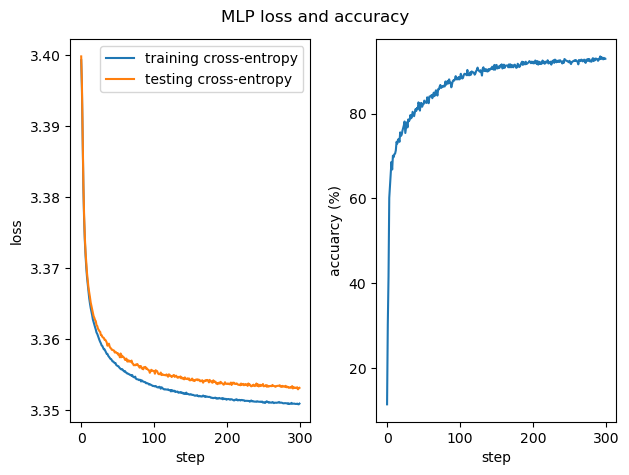

In [17]:
if TRAIN_MLP:

    n_epochs = 300

    train_losses, test_losses, accuracies, model = train_MLP_batch(train_loader, test_loader, n_epochs, 0.8)
    torch.save(model.state_dict(), "mlp.pth")

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
    plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(range(n_epochs), accuracies)
    plt.xlabel('step')
    plt.ylabel('accuarcy (%)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("MLP loss and accuracy")
    plt.show()

The MLP did converge to an accuracy of ~93% in 300 epochs, but the training time was over 7 minutes, which is fairly long for a lightweight model like ours. As shown in the codeblock where we declared the MLP class, the network has over 160,000 parameters with just a single hiddne layer. In the next section, we introduce a different model architecture that resolves these issues.

## Convolutional Neural Network (CNN) - LeNet5 

While an MLP can perform image classification, it typically requires the image data to be flattened, which results in the loss of spatial information. Consequently, MLPs generally perform worse on image data compared to CNNs, as they cannot effectively capture spatial features.

CNNs, however, excel at image classification because they preserve the spatial structure of images through convolutional layers. These layers also reduce the number of parameters by sharing weights, enhancing the model's ability to learn intricate patterns. As a result, CNNs tend to achieve higher accuracy and efficiency in image classification tasks, especially when dealing with large-scale datasets and complex visual patterns.

For the purpose of Hangul classification, we will recreate the LeNet-5 architecture, a CNN structure proposed by LeCun et al. We will assess whether LeNet-5 can outperform the MLP shown in the previous section.  

The LeNet-5 Architecture is shown below:  
</br>
<img src="LeNet.png" width="400">  
</br>
By Cmglee - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=104937230

The code block below implements the LeNet5 architecture shown in the diagram above. The model details are also printed below the code block.

In [10]:
# Define LeNet object

class LeNet(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, num_classes):
        """
        Constructor for LeNet object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(LeNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),

            nn.Linear(in_features= 400, out_features=120),
            nn.ReLU(),

            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),

            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        # First Conv Layer
        
        return self.layers(x)

print(summary(LeNet(30).to(device), (1,28,28)))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 30]                  --
|    └─Conv2d: 2-1                       [-1, 6, 28, 28]           156
|    └─ReLU: 2-2                         [-1, 6, 28, 28]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 14, 14]           --
|    └─Conv2d: 2-4                       [-1, 16, 10, 10]          2,416
|    └─ReLU: 2-5                         [-1, 16, 10, 10]          --
|    └─AvgPool2d: 2-6                    [-1, 16, 5, 5]            --
|    └─Flatten: 2-7                      [-1, 400]                 --
|    └─Linear: 2-8                       [-1, 120]                 48,120
|    └─ReLU: 2-9                         [-1, 120]                 --
|    └─Linear: 2-10                      [-1, 84]                  10,164
|    └─ReLU: 2-11                        [-1, 84]                  --
|    └─Linear: 2-12                      [-1, 30]                  2,550


In [1]:
def train_LeNet(trainloader: DataLoader, testloader: DataLoader, n_epochs: int, learning_rate: float):
    """
    Trains a model using the LeNet5 architecture

    Args:
        trainloader (Datalodaer): PyTorch Dataloader object with training set
        testloader (Dataloader): PyTorch Dataloader object with testing set
        n_epochs (int): Number of epochs
        learning_rate (float): Learning rate of model

    Returns:
        train_losses (list): List of train losses over n_epochs
        test_losses (list): List of test losses over n_epochs
        accuracies (list): List of accuracies over n_epochs
        model (LeNet): Trained LeNet model
    """
    model = LeNet(num_classes = 30).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = np.zeros((n_epochs,))
    test_losses = np.zeros((n_epochs,))
    accuracies = np.zeros((n_epochs,))

    start = time.time()
    for epoch in range(n_epochs):

        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


        model.eval()
        with torch.no_grad():

            total_test_loss, total_train_loss, correct_preds = 0.0, 0.0, 0.0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                test_outputs = model(images)
                test_loss = criterion(test_outputs, labels)
                total_test_loss += test_loss.item()
                
                _, preds = torch.max(test_outputs, 1)
                correct_preds += (preds == labels).sum().item()
            
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                train_outputs = model(images)
                train_loss = criterion(train_outputs, labels)
                total_train_loss += train_loss.item()
            
            accuracies[epoch] = correct_preds / len(testloader.dataset) * 100 # type: ignore
            test_losses[epoch] = total_test_loss / len(testloader)
            train_losses[epoch] = total_train_loss / len(trainloader)
            
            # print every 5 epochs to reduce text output
            if epoch == 0 or (epoch+1)%5 == 0:
                print('Epoch: %03d/%03d | Accuracy: %.3f%%' %(epoch + 1, n_epochs, accuracies[epoch]))
        
    print("Total Train Time: %.2f min" % ((time.time() - start)/60))
    return train_losses, test_losses, accuracies, model

A learning rate of 0.001 was selected since that was the learning rate used in the LeNet5 paper. However, the original LeNet was trained on the MNIST dataset, which has 60,000 images, compared to our 2,400 images. Since our dataset is much smaller, we will try training the model with a higher learning rate (0.005) and compare how it affects our model's performance.

Epoch: 001/050 | Accuracy: 53.056%
Epoch: 005/050 | Accuracy: 92.292%
Epoch: 010/050 | Accuracy: 96.250%
Epoch: 015/050 | Accuracy: 97.500%
Epoch: 020/050 | Accuracy: 97.847%
Epoch: 025/050 | Accuracy: 97.361%
Epoch: 030/050 | Accuracy: 98.333%
Epoch: 035/050 | Accuracy: 98.542%
Epoch: 040/050 | Accuracy: 99.167%
Epoch: 045/050 | Accuracy: 98.403%
Epoch: 050/050 | Accuracy: 99.028%
Total Train Time: 1.31 min
Epoch: 001/050 | Accuracy: 78.819%
Epoch: 005/050 | Accuracy: 95.139%
Epoch: 010/050 | Accuracy: 97.083%
Epoch: 015/050 | Accuracy: 98.056%
Epoch: 020/050 | Accuracy: 98.194%
Epoch: 025/050 | Accuracy: 98.194%
Epoch: 030/050 | Accuracy: 98.472%
Epoch: 035/050 | Accuracy: 98.403%
Epoch: 040/050 | Accuracy: 99.167%
Epoch: 045/050 | Accuracy: 98.819%
Epoch: 050/050 | Accuracy: 97.431%
Total Train Time: 1.40 min


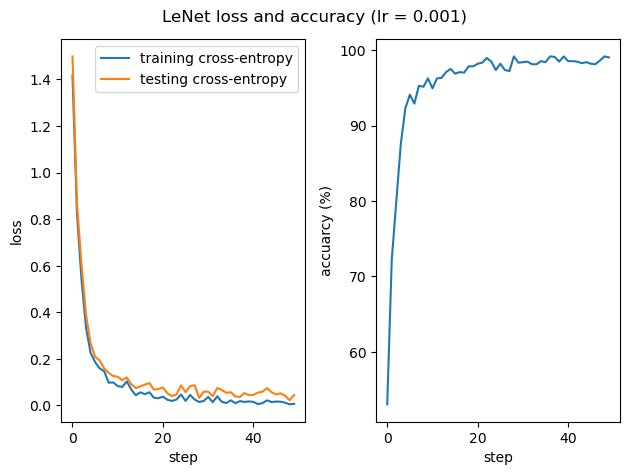

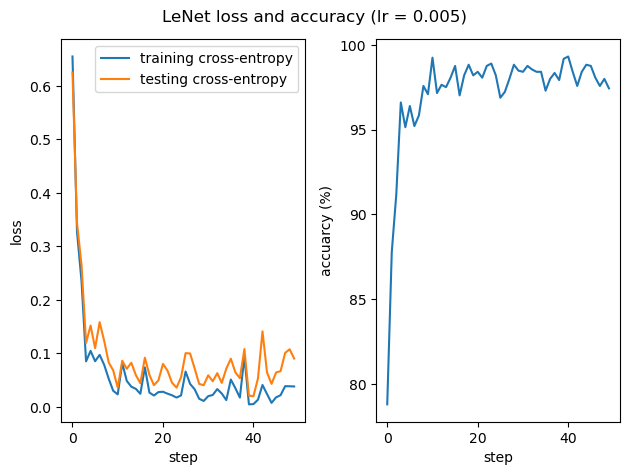

In [18]:
if TRAIN_LENET:
    n_epochs = 50

    lr = 0.001

    train_losses_1, test_losses_1, accuracies_1, model_1 = train_LeNet(train_loader, test_loader, n_epochs=n_epochs, learning_rate=lr)
    torch.save(model_1.state_dict(), "lenet_1.pth")

    train_losses_2, test_losses_2, accuracies_2, model_2 = train_LeNet(train_loader, test_loader, n_epochs=n_epochs, learning_rate=lr*5)
    torch.save(model_2.state_dict(), "lenet_2.pth")

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(range(n_epochs), train_losses_1, label='training cross-entropy')
    plt.plot(range(n_epochs), test_losses_1, label='testing cross-entropy')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(n_epochs), accuracies_1)
    plt.xlabel('step')
    plt.ylabel('accuarcy (%)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("LeNet loss and accuracy (lr = 0.001)")
    plt.show()

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(range(n_epochs), train_losses_2, label='training cross-entropy')
    plt.plot(range(n_epochs), test_losses_2, label='testing cross-entropy')
    plt.xlabel('step')
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(n_epochs), accuracies_2)
    plt.xlabel('step')
    plt.ylabel('accuarcy (%)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("LeNet loss and accuracy (lr = 0.005)")
    plt.show()

As shown above, both LeNet models achieved an accuracy of 97%~99% in ~1 minute 30 seconds in only 50 epochs, which is about five times faster than the MLP architecture. This speed difference is due to convolutional layers having significantly fewer parameters than fully-connected layers, allowing the model to train faster. Additionally, the structure of convolutional layers is better suited for capturing unique features across different classes, which contributes to the overall improvement in classification accuracy.

## Model Evaluation

In [19]:
# Load saved model

mlp = Hangul_MLP(input_size=784, num_classes=30)
mlp.load_state_dict(torch.load('mlp.pth'))

# We will use `lenet_1.pth for this comparision`
lenet = LeNet(num_classes=30)
lenet.load_state_dict(torch.load('lenet_1.pth'))

<All keys matched successfully>

A common method for evaluating a classification model is by using a confusion matrix. This matrix enables the calculation of metrics such as True Positives, True Negatives, False Positives, and False Negatives. These metrics can then be used to determine measures like Precision and Recall.

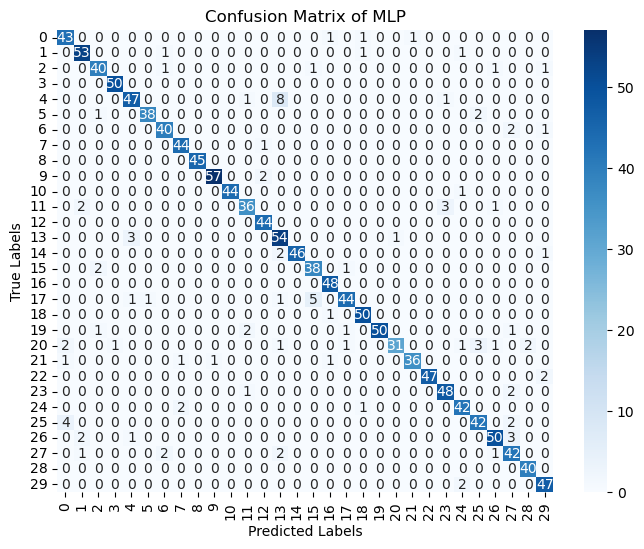

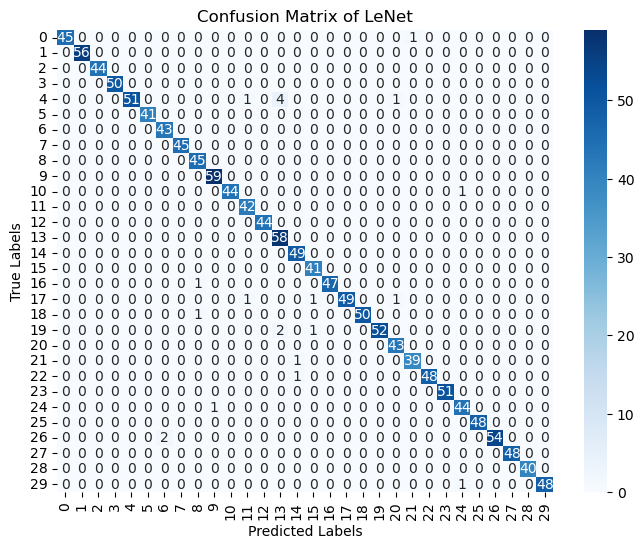

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mlp_preds = []
mlp_true_labels = []

lenet_preds = []
lenet_true_labels = []

with torch.no_grad():
    for imgs, labels_true in test_loader:

        output_mlp = mlp(imgs.view(imgs.size(0), -1))
        output_lenet = lenet(imgs)

        _, labels_pred_mlp = torch.max(output_mlp, 1)
        _, labels_pred_lenet = torch.max(output_lenet, 1)

        mlp_preds.extend(labels_pred_mlp.numpy())
        mlp_true_labels.extend(labels_true.numpy())

        lenet_preds.extend(labels_pred_lenet.numpy())
        lenet_true_labels.extend(labels_true.numpy())

conf_matrix_mlp = confusion_matrix(mlp_true_labels, mlp_preds)
conf_matrix_lenet = confusion_matrix(lenet_true_labels, lenet_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of MLP')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_lenet, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of LeNet')
plt.show()

The confusion matrix above shows that both the MLP and LeNet perform extremely well on the test images, which is shown by the diagonal line where the predicted label matches the true label. One thing to note is that there were two classes that the LeNet often made errors on in previous iterations of the confusion matrix. There were 13 images predicted to be class #15 that turned out to be class #17 and 9 images predicted to be class 28 that turned out to be class #18. We visualize these classes below.

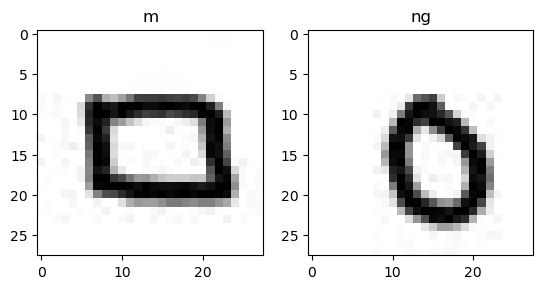

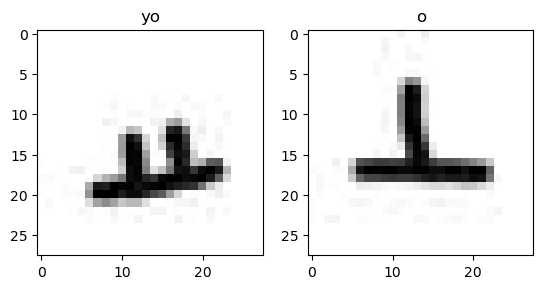

In [15]:
classes = dataset_unaug.classes

# class 15 vs class 17

plt.subplot(1,2,1)
img1, label1 = dataset_unaug[15*80]
plt.imshow(img1.squeeze().numpy(), cmap='gray')
plt.title(classes[label1])

plt.subplot(1,2,2)
img2, label2 = dataset_unaug[17*80]
plt.imshow(img2.squeeze().numpy(), cmap='gray')
plt.title(classes[label2])
plt.show()

# class 28 vs class 18
plt.subplot(1,2,1)
img1, label1 = dataset_unaug[28*80]
plt.imshow(img1.squeeze().numpy(), cmap='gray')
plt.title(classes[label1])

plt.subplot(1,2,2)
img2, label2 = dataset_unaug[18*80]
plt.imshow(img2.squeeze().numpy(), cmap='gray')
plt.title(classes[label2])
plt.show()

Upon examining these 4 classes, we observed that the two characters share many visual similarities. As a native Korean speaker, I find that poorly written `(m, ng)` and `(yo, o)` characters can be difficult to distinguish, even for native speakers. This issue may stem from the limited dataset, which contains only 80 images per class. As a result, the dataset might have failed to capture the small, distinct visual features that differentiate these similar classes.

## Real World Applications

At this stage, the model performs well enough to be integrated into a learning tool where students can write specific Hangul characters in a designated area to test their knowledge. However, it may face challenges in other applications due to limitations in the dataset. For example, if we aimed to develop a tool similar to Google Translate that translates characters from photos taken by users, the model will have poor performance. The dataset consists entirely of black characters on white backgrounds, which could hinder its effectiveness in real-world scenarios where characters may not contrast as clearly with the background. Additionally, the dataset does not account for instances where parts of the characters may be cropped, which could further impact performance.